In [11]:
!pip install fvcore
!pip install torchist

Imports

In [12]:
from fvcore.nn import FlopCountAnalysis
import torch
import torchist
import torch.nn as nn
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load an image from MNIST to use in the report B

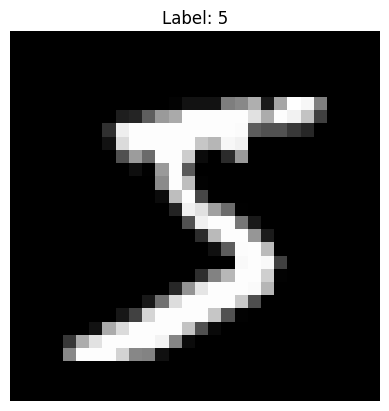

In [13]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Selected an image to display
image_index = 0
image = train_images[image_index]
label = train_labels[image_index]

# Display the image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()


Define a baseline ViT model with 4 Transformer Encoder Layers to compare with the DD ViT model

In [14]:
class BaselineTransformer(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.embedding = nn.Linear(28, input_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=4) # Assign 4 Transformer Encoder Layers for the baseline model
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = x.squeeze(1)  # Remove the channel dimension: (batch_size, 28, 28)
        x = x.permute(0, 2, 1)  # Reshape to (batch_size, length_seq, input_dim)
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)  # Global average pooling
        return self.fc(x)


Defining the DynamicDepthVisualEncoding class with entropy complexity calculation to determine the number of Transformer Encoder Layers

In [15]:
class DyanimcDepthVisualEncoding(nn.Module):
    def __init__(self, input_dim, num_classes, max_layers=4):
        super().__init__()
        self.embedding = nn.Linear(28, input_dim)
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=4, batch_first=True)
            for _ in range(max_layers)
        ])
        self.fc = nn.Linear(input_dim, num_classes)

    def compute_entropy(self, x):
        # Flatten the image to compute histogram
        x_flat = x.view(x.size(0), -1)
        entropy_values = []
        for img in x_flat:
            # Normalize the embedded inputs between 0 and 1
            img_min, img_max = img.min(), img.max()
            img_normalized = (img - img_min) / (img_max - img_min)

            # Compute histogram in [0, 1] range
            hist = torchist.histogramdd(img_normalized.unsqueeze(1), bins=256, low=0.0, upp=1.0)
            # Normalize histogram to get a probability distribution
            prob_dist = hist / hist.sum()
            # Compute entropy
            entropy = -torch.sum(prob_dist * torch.log2(prob_dist + 1e-9))
            entropy_values.append(entropy)
        return torch.stack(entropy_values)

    def forward(self, x):
        x = x.squeeze(1)  # Remove the channel dimension: (batch_size, 28, 28)
        x = x.permute(0, 2, 1)  # Reshape to (batch_size, length_seq, input_dim)
        x = self.embedding(x)

        # Compute entropy-based complexity
        entropy = self.compute_entropy(x)

        # Normalize entropy to range [0, 1]
        entropy_normalized = entropy/8.0
        # Determine number of layers to use based on normalized entropy
        num_layers_to_use = torch.clamp((entropy_normalized * len(self.encoder_layers)).long(), 1, len(self.encoder_layers))
        for i, layer in enumerate(self.encoder_layers):
            if (i + 1) > num_layers_to_use.max():
                break
            x = layer(x)

        x = x.mean(dim=1) # Global average pooling
        return self.fc(x)




Get the mnist dataset and split into training and testing for both baseline and DD ViT model

In [16]:
def get_mnist_dataloaders(batch_size=64):
    # Transform the images to normalize them
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0 and std 1
    ])

    # Download dataset
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    # Define proper dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader


Training and evaluation loop for both models

In [20]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train() # Train model

    for epoch in range(epochs):
        current_loss = 0.0
        right = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            current_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            right += predicted.eq(labels).sum().item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {current_loss/len(train_loader):.4f}, Accuracy: {100*right/total:.2f}%")


def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval() # Evaluate model

    right = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            right += predicted.eq(labels).sum().item()

    print(f"Test Accuracy: {100*right/total:.2f}%")



Simple method to calculate the number of floating-point operations per second (FLOPs)

In [18]:
def calculate_flops(model, dummy_input):
    flops = FlopCountAnalysis(model, dummy_input)
    print(f"FLOPs: {flops.total()}")
    return flops.total()


In [21]:
if __name__ == "__main__":
    # Define the parameters
    batch_size = 64
    input_dim = 64
    num_classes = 10
    epochs = 5
    learning_rate = 0.001
    criterion = nn.CrossEntropyLoss()

    # Load data from MNIST dataset
    train_loader, test_loader = get_mnist_dataloaders(batch_size)

    # Define dummy input for FLOP calculation and put it to device
    dummy_input = torch.rand(batch_size, 1, 28, 28).to(device)

    # Train and evaluate Baseline Model using crossentropy loss and the Adam optimizer for simplicity
    print("Training Baseline Model:")
    baseline_model = BaselineTransformer(input_dim, num_classes)
    optimizer = optim.Adam(baseline_model.parameters(), lr=learning_rate)
    train_model(baseline_model, train_loader, criterion, optimizer, epochs)

    print("Evaluating Baseline Model:")
    evaluate_model(baseline_model, test_loader)

    print("FLOPs for Baseline Model: ")
    calculate_flops(baseline_model, dummy_input)

    # Train and evaluate DD ViT using same crossentropy loss formula and the Adam optimizer
    # Parameters remain the same for proper comparison
    print("\nTraining DD ViT:")
    dd_vit_model = DyanimcDepthVisualEncoding(input_dim, num_classes)
    optimizer = optim.Adam(dd_vit_model.parameters(), lr=learning_rate)
    train_model(dd_vit_model, train_loader, criterion, optimizer, epochs)

    print("Evaluating DD ViT Model...")
    evaluate_model(dd_vit_model, test_loader)

    print("FLOPs for DD ViT Model...")
    calculate_flops(dd_vit_model, dummy_input)


Training Baseline Model:
Epoch 1/5, Loss: 0.5315, Accuracy: 82.61%
Epoch 2/5, Loss: 0.2582, Accuracy: 92.08%
Epoch 3/5, Loss: 0.2033, Accuracy: 93.54%
Epoch 4/5, Loss: 0.1744, Accuracy: 94.62%
Epoch 5/5, Loss: 0.1578, Accuracy: 95.08%
Evaluating Baseline Model:


transformer.layers.0.self_attn.out_proj, transformer.layers.1.self_attn.out_proj, transformer.layers.2.self_attn.out_proj, transformer.layers.3.self_attn.out_proj


Test Accuracy: 94.73%
FLOPs for Baseline Model: 
FLOPs: 2004328448

Training DD ViT:
Epoch 1/5, Loss: 0.4631, Accuracy: 85.22%
Epoch 2/5, Loss: 0.2252, Accuracy: 92.94%
Epoch 3/5, Loss: 0.1800, Accuracy: 94.36%
Epoch 4/5, Loss: 0.1550, Accuracy: 95.10%
Epoch 5/5, Loss: 0.1415, Accuracy: 95.50%
Evaluating DD ViT Model...
Test Accuracy: 95.50%
FLOPs for DD ViT Model...


encoder_layers.0.self_attn.out_proj, encoder_layers.1.self_attn.out_proj, encoder_layers.2.self_attn.out_proj, encoder_layers.3, encoder_layers.3.dropout, encoder_layers.3.dropout1, encoder_layers.3.dropout2, encoder_layers.3.linear1, encoder_layers.3.linear2, encoder_layers.3.norm1, encoder_layers.3.norm2, encoder_layers.3.self_attn, encoder_layers.3.self_attn.out_proj


FLOPs: 1504059392
